In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd

from pysabr import Hagan2002LognormalSABR

import yfinance as yf
spx = yf.Ticker("^SPX")

current_price = spx.info["regularMarketPrice"]

df = pd.concat([spx.option_chain(x).calls for x in spx.options])
df['contractSymbol'] = dates_numeric = df['contractSymbol'].str.replace(r"[a-zA-Z]", '').map(lambda x: str(x)[:-8])
df['contractSymbol'] = pd.to_datetime(df['contractSymbol'], format='%y%m%d')

maturities = df['contractSymbol'].unique()
df.head(10)


C:\Users\somig\AppData\Local\Temp/ipykernel_2408/2497242431.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['contractSymbol'] = dates_numeric = df['contractSymbol'].str.replace(r"[a-zA-Z]", '').map(lambda x: str(x)[:-8])


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,2021-08-02,2021-08-02 13:42:26,3400.0,1017.28,980.6,986.8,17.730042,1.773802,2.0,2.0,2.007329,1.0,REGULAR,USD
1,2021-08-02,2021-07-30 14:50:34,3475.0,941.68,908.4,912.7,17.130005,1.852794,5.0,5.0,2.009282,1.0,REGULAR,USD
2,2021-08-02,2021-07-02 15:41:45,3500.0,833.50,0.0,0.0,0.000000,0.000000,2.0,1.0,0.000010,1.0,REGULAR,USD
3,2021-08-02,2021-07-30 13:42:05,3750.0,663.92,631.8,638.4,13.380005,2.056754,4.0,0.0,1.490237,1.0,REGULAR,USD
4,2021-08-02,2021-07-30 13:42:05,3770.0,643.89,610.6,616.8,13.330017,2.113997,4.0,4.0,1.264896,1.0,REGULAR,USD
5,2021-08-02,2021-07-30 19:46:45,3810.0,583.33,571.8,578.0,-0.109985,-0.018851,10.0,10.0,1.325443,1.0,REGULAR,USD
6,2021-08-02,2021-08-02 19:32:10,3825.0,568.17,558.8,562.8,-1.820007,-0.319305,10.0,0.0,0.808596,1.0,REGULAR,USD
7,2021-08-02,2021-08-02 19:40:00,3860.0,530.46,521.7,530.0,-3.849976,-0.720551,10.0,10.0,0.824221,1.0,REGULAR,USD
8,2021-08-02,2021-07-12 19:02:10,3875.0,509.50,506.8,513.0,0.000000,0.000000,1.0,0.0,1.188114,1.0,REGULAR,USD
9,2021-08-02,2021-08-02 14:07:31,3890.0,521.42,491.8,498.0,11.429993,2.241219,6.0,6.0,1.156498,1.0,REGULAR,USD


In [1]:
import time
import datetime

current_time = time.localtime()

def delta_t(m):

    now = pd.to_datetime(time.strftime('%Y-%m-%d %H:%M:%S', current_time))
    delta_t = m - now
    year_dt = datetime.timedelta(365,0,0,0)

    return round(delta_t/year_dt, 6)


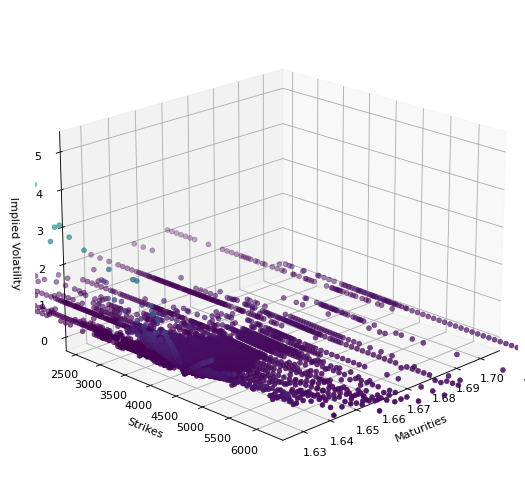

In [60]:
# 3d surface plot

polished_df = df[df["strike"] >= 3500]
polished_df = polished_df[polished_df["strike"] <= 5700]

x = pd.to_numeric(df["contractSymbol"])
y = df["strike"]
z = df["impliedVolatility"]


def plot3d(x, y, z, rng=current_price, scatter=True):
    fig = plt.figure(figsize=(15, 8), dpi=80)

    ax = plt.axes(projection='3d')
    if scatter:
        ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=.5)
    else:
        ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none');



    ax.set_xlabel('Maturities')
    ax.set_ylabel('Strikes')
    ax.set_zlabel('Implied Volatility')

    ax.set_ylim((current_price - rng, current_price + rng))
    
    ax.invert_xaxis()
    ax.view_init(20, 45)
    

    plt.show()

plot3d(x, y, z, 2000)  

In [29]:
#2d volatility smiles

def plot2d(x, y):
    fig = plt.figure(figsize=(6, 4), dpi=80)
    ax = fig.gca()

    ax.plot(x, y)

    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatility')
    ax.set_xbound(4000, 6000)

    plt.show()


In [8]:
# SABR MANUAL MODELLING 
from scipy.optimize import minimize
from pysabr import Hagan2002NormalSABR
from pysabr import black


def sigma_black (alpha, beta, nu, rho, strikes, prices, maturity):
    vector_sigma = np.zeros(len(strikes))
    i = 0
    for K, S in zip(strikes, prices):
        sabr = Hagan2002NormalSABR(f=prices[i], shift=0, t=delta_t(maturity), v_atm_n=nu, beta=beta, rho=rho, volvol=alpha)
        vector_sigma[i] = sabr.normal_vol(K)
        i += 1
    return vector_sigma
    
def volatilitySmile (maturity):

    sabr = Hagan2002NormalSABR()

    option = df[df["contractSymbol"] == maturity]

    def objectiveFunction (X):

        def normal_vol(k, f, t, alpha, beta, rho, volvol):
            """Hagan's 2002 SABR normal vol expansion - formula (B.67a)."""
            # We break down the complex formula into simpler sub-components
            f_av = np.sqrt(f * k)
            A = - beta * (2 - beta) * alpha**2 / (24 * f_av**(2 - 2 * beta))
            B = rho * alpha * volvol * beta / (4 * f_av**(1 - beta))
            C = (2 - 3 * rho**2) * volvol**2 / 24
            FMKR = _f_minus_k_ratio(f, k, beta)
            ZXZ = _zeta_over_x_of_zeta(k, f, t, alpha, beta, rho, volvol)
            # Aggregate all components into actual formula (B.67a)
            v_n = alpha * FMKR * ZXZ * (1 + (A + B + C) * t)
            return v_n

        formula = 0
        strikes_v = option["strike"].to_numpy()
        # sigma_BS = sigma_black(X[0], beta=1, nu=X[1], rho=X[2], strikes=option["strike"], prices=option["lastPrice"], maturity=maturity)
        sigma_BS = X[0]/(X[1]+X[2])
        for i in range(len(strikes_v)):
            impliedVolatility = option[option["strike"] == strikes_v[i]]["impliedVolatility"].to_numpy()[0]
            #formula += (impliedVolatility - sigma_BS[i])**2
            formula += (impliedVolatility - sigma_BS)**2
        return formula
        
    x0 = [1, 2, 1]
    bnds = ((0, 10**13), (0, 10**13), (-1, 1))
    solution = minimize(objectiveFunction, x0, method="SLSQP", bounds=bnds)
    (alpha, rho, nu) = solution.x

    sigma_SABR = sigma_black(alpha, beta=1, nu=nu, rho=rho, strikes=option["strike"], prices=option["lastPrice"], maturity=maturity)

    return dict(maturity=maturity, moneyness=option["strike"], IV=sigma_SABR)


In [ ]:
def calibration(model):
    volatilityMatrix = np.matrix()

    if model == "sabr": 
        for m in range(len(maturities)):
            np.append(volatilityMatrix, [volatilitySmile(maturities[i])], axis= 0)
    elif model == "shift":
        np.append(volatilityMatrix, [shiftedVolatilitySmile(maturities[i])], axis= 0)

    return volatilityMatrix

def volatilitySurface(df):
    
    maturities = df["contractSymbol"].unique()
    option_array = []

    for m in maturities:
        smile = volatilitySmile(maturity=m)
        option_array.append(smile)
    
    return option_array


def unpack_vol (option_array):
    arr = []
    for d in option_array:
        arr.extend(d["IV"])
    return arr

x = pd.to_numeric(df["contractSymbol"])
y = df["strike"]
z = unpack_vol(volatilitySurface(df))

plot3d(x, y, z)

In [36]:
#SABR PYASABR VOLATILITY MODELLING

maturities = np.array(df["contractSymbol"].unique())
delta_maturities = np.array([delta_t(m) for m in maturities])
strikes = np.array(df["strike"].unique())

def volatilitySmile(m, shift=0, beta=0.5):

    option = df[df["contractSymbol"] == m]
    strikes = option["strike"]
    dt = delta_maturities[np.where(maturities == m)[0][0]] 

    sabr = Hagan2002LognormalSABR(f=current_price, shift=shift, t=dt, beta=beta)
    [alpha, rho, volvol] = sabr.fit(strikes, dt)

    volatility_vector = np.array([sabr.lognormal_vol(k) for k in strikes])

    return (m, np.array(option["strike"]), volatility_vector)

def volatilitySurface():
    
    option_array = []

    for m in maturities:
        smile = volatilitySmile(m)
        option_array.append(smile)
    
    return option_array


In [ ]:
#construct plotting matrix

option_matrix = volatilitySurface()

def volatility_vector (option_matrix):
    vols = []
    for item in option_array:
        vols.extend(item[-1])
    return vols


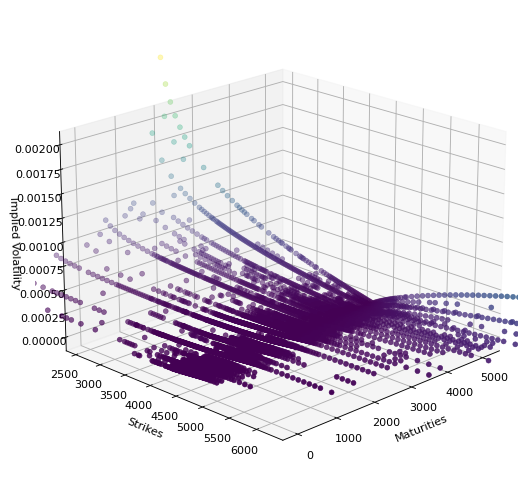

In [85]:
x = range(len(df["contractSymbol"]))
y = df["strike"]
z = unpack_vol(option_matrix)

plot3d(x, y, z, 2000)